In [4]:
import os
import sys

sys.path.append(os.getcwd() + "/")

from experiments import setup_experiments

exps = setup_experiments("exp205")

In [7]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

no_bias = Path(exps.path) / "test" / "no_bias"
bias = Path(exps.path) / "test" / "bias"
csv = Path(exps.path) / "test.csv"

no_bias_macaw_cf = Path(exps.path) / "macaw_cfs" / "no_bias"
bias_macaw_cf = Path(exps.path) / "macaw_cfs" / "bias"

df = pd.read_csv(csv, low_memory=True)

In [8]:
from tifffile import tifffile as tiff


def four_images(idx, df):
    no_bias_img = tiff.imread(os.path.join(no_bias, df.iloc[idx]["filename"])).squeeze()
    bias_img = tiff.imread(os.path.join(bias, df.iloc[idx]["filename"])).squeeze()

    no_bias_macaw_cf_img = tiff.imread(
        os.path.join(no_bias_macaw_cf, df.iloc[idx]["filename"])
    ).squeeze()
    bias_macaw_cf_img = tiff.imread(
        os.path.join(bias_macaw_cf, df.iloc[idx]["filename"])
    ).squeeze()

    return no_bias_img, bias_img, no_bias_macaw_cf_img, bias_macaw_cf_img

In [11]:
import numpy as np


def view_images(idx):
    no_bias_img, bias_img, no_bias_macaw, bias_macaw = four_images(idx, df)

    fig, axs = plt.subplots(2, 5, figsize=(8, 8))
    [
        a.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        for ax in axs
        for a in ax
    ]

    fig.delaxes(axs[0, 0])
    fig.delaxes(axs[0, 4])

    axs[0, 0].imshow(no_bias_img, cmap="gray")
    axs[0, 0].set_title("No bias")

    axs[0, 1].imshow(no_bias_macaw, cmap="gray")
    axs[0, 1].set_title("No bias CF")

    axs[0, 2].imshow(bias_img, cmap="gray")
    axs[0, 2].set_title("Bias")

    axs[0, 3].imshow(bias_macaw, cmap="gray")
    axs[0, 3].set_title("Bias CF")

    # fig.delaxes(axs[1, 0])

    axs[1, 0].imshow(bias_img - no_bias_img, cmap="seismic", clim=(-1, 1))
    axs[1, 0].set_title("Bias - No bias")

    axs[1, 1].imshow(bias_img - no_bias_macaw, cmap="seismic", clim=(-1, 1))
    axs[1, 1].set_title("Bias - No bias CF")

    axs[1, 2].imshow(bias_macaw - no_bias_img, cmap="seismic", clim=(-1, 1))
    axs[1, 2].set_title("Bias CF - No bias")

    axs[1, 3].imshow(bias_macaw - no_bias_macaw, cmap="seismic", clim=(-1, 1))
    axs[1, 3].set_title("Bias CF - No bias CF")

    axs[2, 0].imshow(no_bias_img - no_bias_macaw, cmap="seismic", clim=(-1, 1))
    axs[2, 0].set_title("Bias - No bias")

    axs[2, 1].imshow(bias_img - bias_macaw, cmap="seismic", clim=(-1, 1))
    axs[2, 1].set_title("Bias - No bias CF")

    # fig.savefig("results/diff.png")

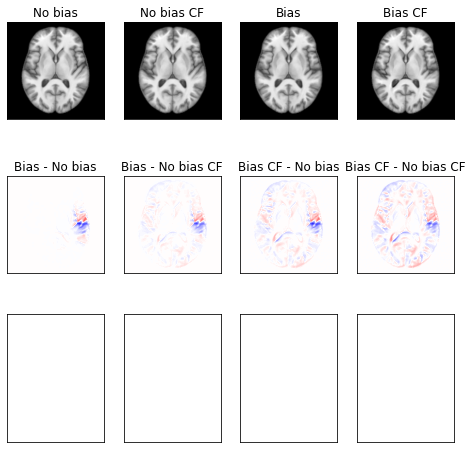

In [12]:
view_images(5)

In [35]:
def TEA(no_bias_img, bias_img, cf_img):
    no_far = (no_bias_img - bias_img).flatten()
    cf_far = (cf_img - bias_img).flatten()

    no_far_mag = np.linalg.norm(no_far)
    cf_far_mag = np.linalg.norm(cf_far)
    projection = no_far.dot(cf_far) / no_far_mag

    bias_removal = projection / no_far_mag
    unwanted_changes = np.sqrt(cf_far_mag**2 - projection**2)

    return bias_removal, unwanted_changes

In [38]:
n = len(df)

macaw_brs = []
macaw_ucs = []

hvae_brs = []
hvae_ucs = []
for i in range(n):
    no, biased, macaw = three_images(i, df)

    br, uc = TEA(no, biased, macaw)
    macaw_brs.append(br)
    macaw_ucs.append(uc)

df["MACAW_effectiveness"] = macaw_brs
df["MACAW_amplification"] = macaw_ucs

In [39]:
df["bias_effect"] = [float(i.split("_")[-2]) for i in df["filename"]]
df["disease_effect"] = [float(i.split("_")[3]) for i in df["filename"]]
df["subject_effect"] = [float(i.split("_")[1]) for i in df["filename"]]
df["isv_dst_abs"] = np.abs(df["isv_dst"])

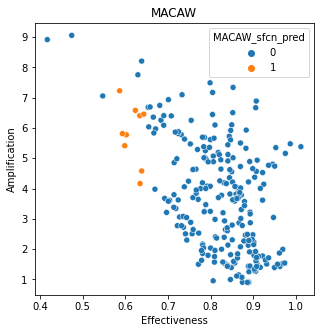

In [52]:
import seaborn as sns

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

sns.scatterplot(
    x="MACAW_effectiveness",
    y="MACAW_amplification",
    hue="MACAW_sfcn_pred",
    data=df,
    ax=axs,
)
axs.set(title="MACAW", xlabel="Effectiveness", ylabel="Amplification")

fig.savefig("results/macaw_sfcn.png")

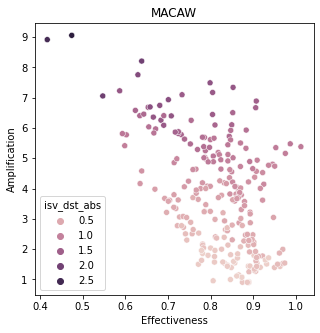

In [53]:
import seaborn as sns

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

sns.scatterplot(
    x="MACAW_effectiveness",
    y="MACAW_amplification",
    hue="isv_dst_abs",
    data=df,
    ax=axs,
)
axs.set(title="MACAW", xlabel="Effectiveness", ylabel="Amplification")
fig.savefig("results/isv.png")